###  Importing neede libraries and defining value formatter

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from matplotlib.ticker import FuncFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [2]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def bilions_formatter(x, pos):
    return f'{x / 1e9} B'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### Lodind the datasets

In [3]:
population_df = pd.read_csv('population_df_1996.csv')
migration_df = pd.read_csv('migration_df_1996.csv')

### Data aggregation for the migration and the population datasets

In [4]:
migration_net_corrected = migration_df[
    (migration_df['Origin or Destination'] == 'Net migration') & 
    (migration_df['Sex'] != 'Both sexes')
]
migration_aggregated_corrected = migration_net_corrected.groupby('Year')['VALUE'].sum().reset_index()


population_total_corrected = population_df[
    (population_df['Single Year of Age'] == 'All ages') & 
    (population_df['Sex'] != 'Both sexes')
]
population_aggregated_corrected = population_total_corrected.groupby('Year')['VALUE'].sum().reset_index()



In [5]:
population_aggregated_corrected.head(7)

,Year,VALUE
0,1996,3626087
1,1997,3664313
2,1998,3703082
3,1999,3741647
4,2000,3789536
5,2001,3847198
6,2002,3917203


In [6]:
migration_aggregated_corrected.head(7)

,Year,VALUE
0,1996,10.3
1,1997,32.1
2,1998,29.5
3,1999,30.4
4,2000,48.2
5,2001,54.8
6,2002,82.7


Merging the datasets on the 'Year' column and then convert the net migration figures to absolute numbers to match the scale of the population figures. 

In [7]:
merged_df_corrected = pd.merge(population_aggregated_corrected, migration_aggregated_corrected, on='Year', how='inner', suffixes=('_pop', '_mig'))

merged_df_corrected.rename(columns={'VALUE_pop': 'Population', 'VALUE_mig': 'Net Migration'}, inplace=True)

# Since Net Migration is in thousands, I'll convert it to absolute numbers for consistency with the population figures
merged_df_corrected['Net Migration'] = merged_df_corrected['Net Migration'] * 1000

merged_df_corrected.head(7)


,Year,Population,Net Migration
0,1996,3626087,10300.0
1,1997,3664313,32100.0
2,1998,3703082,29500.0
3,1999,3741647,30400.0
4,2000,3789536,48200.0
5,2001,3847198,54800.0
6,2002,3917203,82700.0


### Visualizing some valuable Insights.

A time series plot to show the trend of the population over the years.


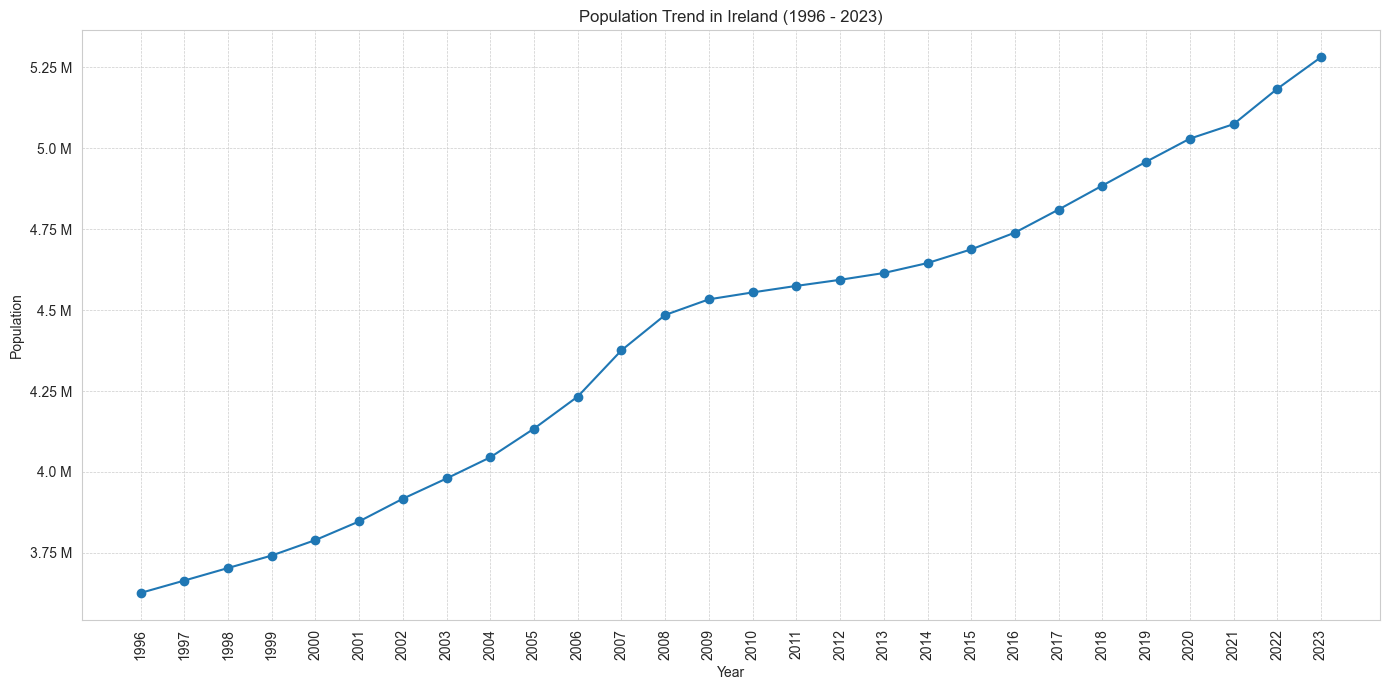

A time series plot to show the trend of net migration over the years.


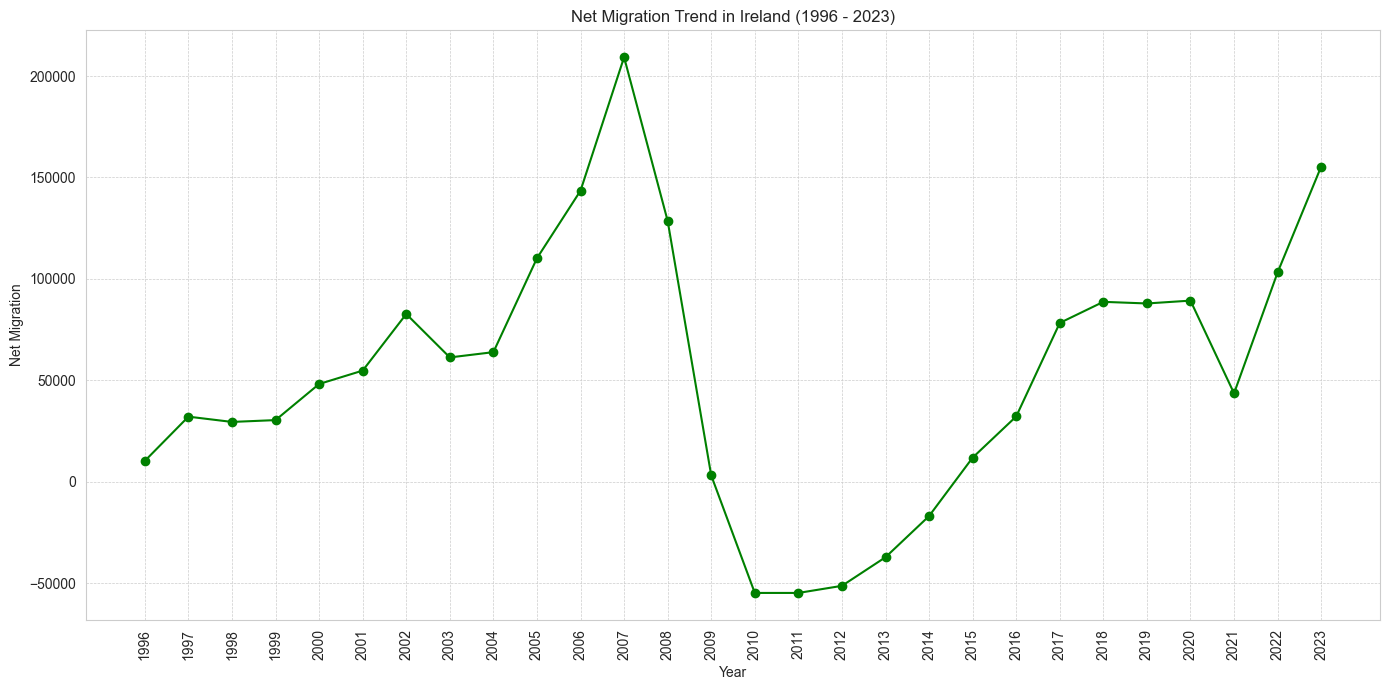

A scatter plot to visualize the relationship between net migration and population.


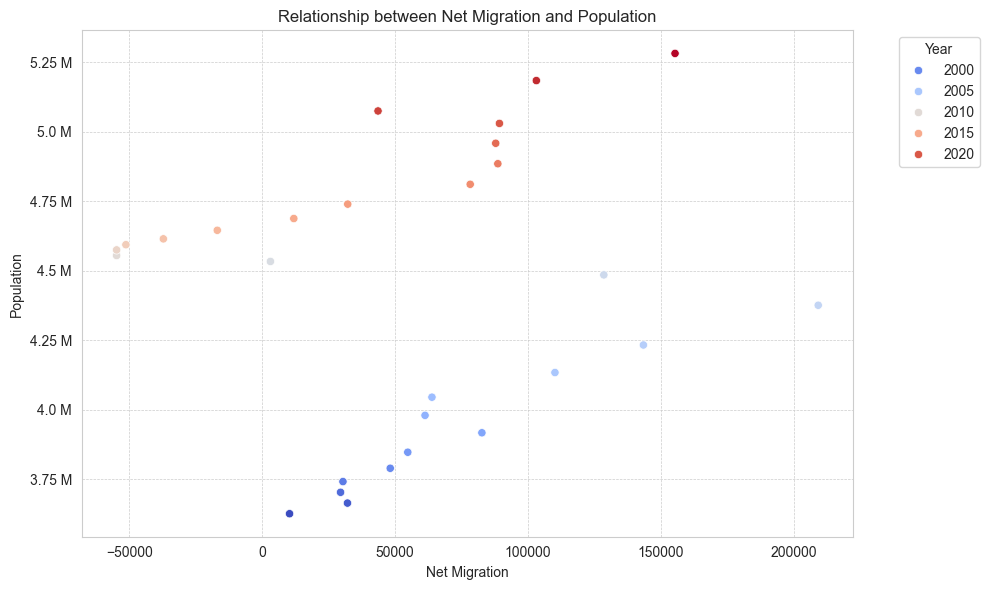

In [8]:
sns.set_style("whitegrid")

print('A time series plot to show the trend of the population over the years.')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Population'], marker='o', linestyle='-')
plt.title('Population Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Population')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

print('A time series plot to show the trend of net migration over the years.')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Net Migration'], marker='o', linestyle='-', color='green')
plt.title('Net Migration Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Net Migration')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print('A scatter plot to visualize the relationship between net migration and population.')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Net Migration', y='Population', data=merged_df_corrected, hue='Year', palette="coolwarm")
plt.title('Relationship between Net Migration and Population')
plt.xlabel('Net Migration')
plt.ylabel('Population')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### **Insights:**
* **Population Trend:** This plot shows the trend of the population in Ireland from 1996 to 2023. As we can see there is a consistent increase over the years.

* **Net Migration Trend:** This plot illustrates the trend of net migration over the same period. There are fluctuations from year to year, with some years experiencing negative net migration (more emigrants than immigrants).

* **Relationship between Net Migration and Population:** The scatter plot indicates the relationship between net migration and population size for each year. The color gradient represents the progression of years. It seems that there is a general positive correlation, suggesting that higher net migration is often associated with a higher population in the subsequent years.

### Preparing the data

Splitting the data. I'll use the population as the target variable (y) and the year and net migration as features (X).

In [9]:
X = merged_df_corrected[['Year', 'Net Migration']]
y = merged_df_corrected['Population']

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((22, 2), (6, 2), (22,), (6,))

The data has been split into training and test sets, maintaining chronological order:

* Training set: 22 data points (80% of the data)
* Test set: 6 data points (20% of the data)

###  Training the models

I'll start by training the following models using the training set:

* Ordinary Least Squares (OLS) Regression
* Ridge Regression
* Lasso Regression
* ElasticNet Regression
* Random Forest

I'll also perform hyperparameter tuning for the Ridge, Lasso, ElasticNet and Random Forest models, and finally, I'll evaluate all models on the test set.

#### Training the OLS Regression (it doesn't require hyperparameter tuning)

In [10]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

y_pred_ols = ols_model.predict(X_test)

ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_rmse = mean_squared_error(y_test, y_pred_ols, squared=False)
ols_r2 = r2_score(y_test, y_pred_ols)

metrics_summary = {
    'R2': ols_r2,
    'MAE': ols_mae,
    'RMSE': ols_rmse,
}
metrics_summary

{'R2': 0.880926388939636, 'MAE': 41492.6808142364, 'RMSE': 45885.9002682968}

#### Training the Ridge Regression (using GridSearchCV hyperparameter tuning)

In [11]:
ridge = Ridge()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

metrics_summary = {
    'R2': ridge_r2,
    'MAE': ridge_mae,
    'RMSE': best_alpha_ridge,
    'Best alpha': best_alpha_ridge
}
metrics_summary

{'R2': 0.8848130378899626,
 'MAE': 40850.815560780466,
 'RMSE': 1,
 'Best alpha': 1}

#### Training & Tuning the Lasso Regression (using GridSearchCV hyperparameter tuning)

In [12]:

lasso = Lasso()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

metrics_summary = {
    'R2': lasso_r2,
    'MAE': lasso_mae,
    'RMSE': lasso_rmse,
    'Best alpha': best_alpha_lasso
}
metrics_summary

{'R2': 0.8809406849803105,
 'MAE': 41490.36146771411,
 'RMSE': 45883.14564289537,
 'Best alpha': 10}

####  Trainingn the Random Forest (using GridSearchCV hyperparameter tuning)

In [13]:

random_forest = RandomForestRegressor(random_state=0)

parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}

rf_cv = GridSearchCV(random_forest, parameters, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_

rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_est_num = rf_model.estimator_

metrics_summary = {
    'R2': rf_r2,
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'Best parameters': best_params_rf
}
metrics_summary

{'R2': -5.750360814946282,
 'MAE': 312113.16499999986,
 'RMSE': 345489.60755728395,
 'Best parameters': {'max_depth': 5, 'n_estimators': 100}}

**Insights:**\
The negative R-squared value indicates that the Random Forest model performs worse than a horizontal line fit to the data. This poor performance may be due to overfitting on the training set or not having enough data to capture the complexity that Random Forest can handle.

Based on these results, the Random Forest model does not seem appropriate for my dataset. The linear models, especially the

#### Train the ElasticNet Regression (using GridSearchCV hyperparameter tuning)

In [14]:
elastic_net = ElasticNet()

parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

en_cv = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5)

en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

en_mae = mean_absolute_error(y_test, y_pred_en)
en_rmse = mean_squared_error(y_test, y_pred_en, squared=False)
en_r2 = r2_score(y_test, y_pred_en)

metrics_summary = {
    'R2': en_r2,
    'MAE': en_mae,
    'RMSE': en_rmse,
    'Best parameters': best_params_en
}
metrics_summary

{'R2': 0.8892822424475426,
 'MAE': 40082.365630577006,
 'RMSE': 44246.62353490334,
 'Best parameters': {'alpha': 1, 'l1_ratio': 0.9}}

### Models comparison

Ordinary Least Squares (OLS) Regression:
* MAE: 41,492.68
* RMSE: 45,885.90
* R²: 0.881
  
Ridge Regression (with hyperparameter tuning):
* MAE: 40,850.82
* RMSE: 45,130.81
* R²: 0.885
  
Lasso Regression (with hyperparameter tuning):
* MAE: 41,490.36
* RMSE: 45,883.15
* R²: 0.881

ElasticNet Regression (with hyperparameter tuning):
* MAE: 40082.37
* RMSE: 44246.62
* R²: 0.889
  
Random Forest Regression (with hyperparameter tuning):
* MAE: 312,113.16
* RMSE: 345,489.61
* R²: -5.75

**Insights:**
* The **OLS regression** provided a strong baseline with an R² of 0.881, suggesting that the model explains about 88.1% of the variability in the test data.
* **Ridge regression** showed a slight improvement over OLS, indicating that the L2 regularization helped reduce overfitting and improve the model's generalization on the test data.
* **Lasso regression** did not improve the performance compared to OLS, suggesting that feature selection through L1 regularization was not beneficial, possibly because both features used (year and net migration) were relevant for the model.
* **The Random Forest regression** performed poorly, which might be due to the small dataset size, leading to overfitting despite hyperparameter tuning. The negative R² indicates that the model is worse than a simple mean-based prediction, which is not desirable.

In [15]:
# Data for plotting
model_names = ['OLS', 'Ridge', 'Lasso', 'Random Forest']
mae_values = [ols_mae, ridge_mae, lasso_mae, rf_mae]
rmse_values = [ols_rmse, ridge_rmse, lasso_rmse, rf_rmse]
r2_values = [ols_r2, ridge_r2, lasso_r2, rf_r2]

model_names.append('ElasticNet')
mae_values.append(en_mae)
rmse_values.append(en_rmse)
r2_values.append(en_r2)


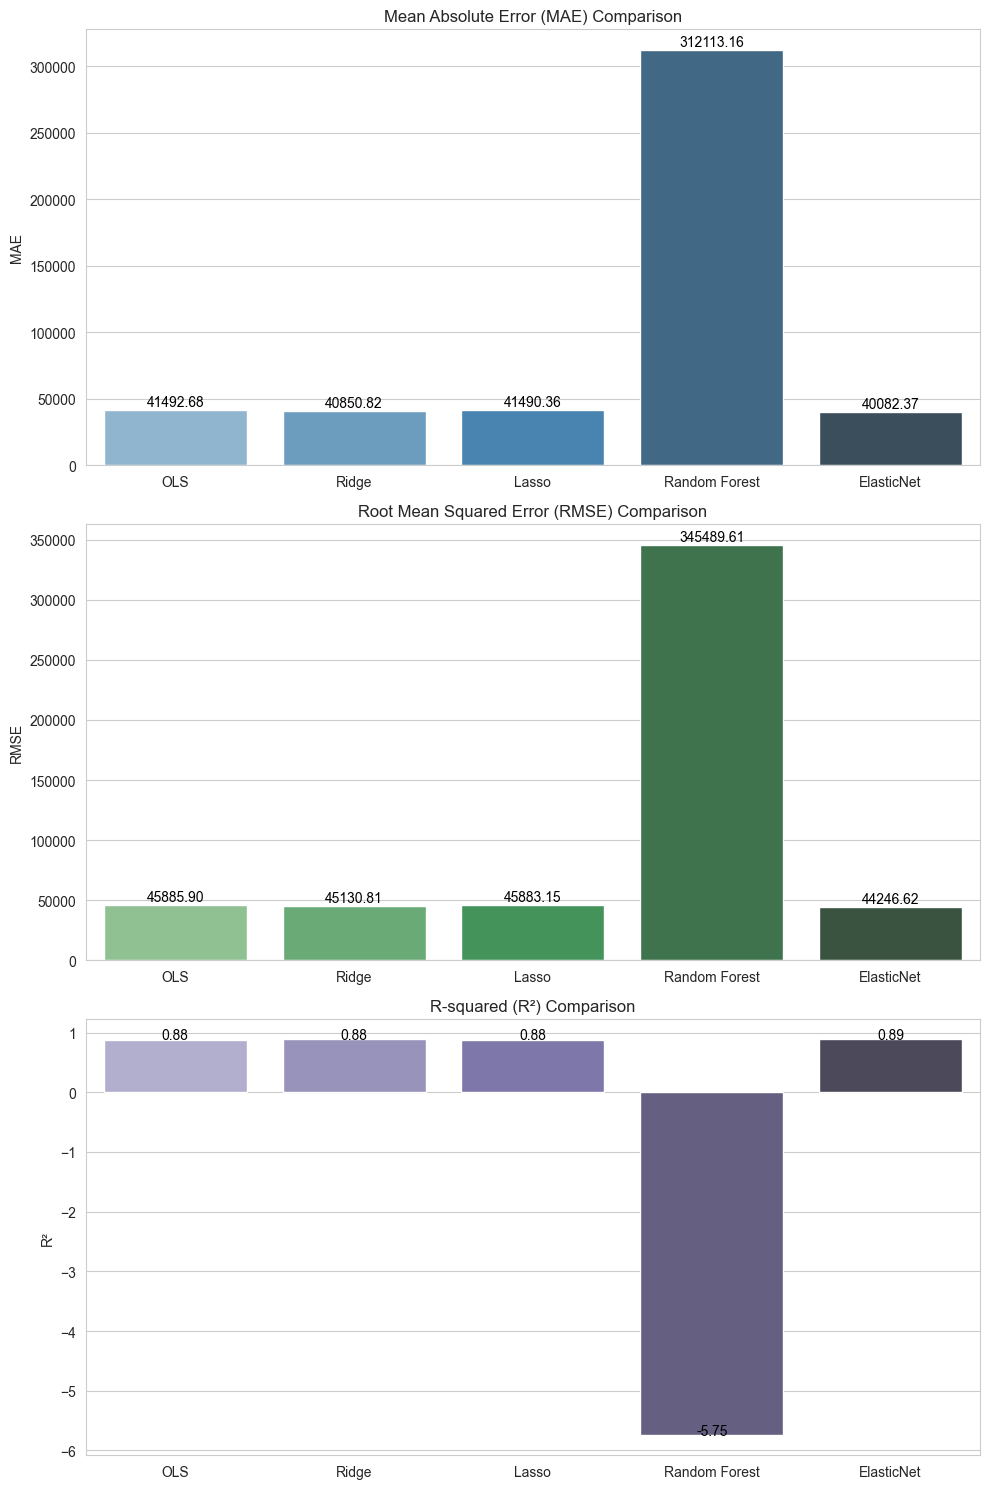

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MAE plot
sns.barplot(ax=ax[0], x=model_names, y=mae_values, palette="Blues_d")
ax[0].set_title('Mean Absolute Error (MAE) Comparison')
ax[0].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    ax[0].text(i, v + max(mae_values)*0.01, f"{v:.2f}", color='black', ha='center')

# RMSE plot
sns.barplot(ax=ax[1], x=model_names, y=rmse_values, palette="Greens_d")
ax[1].set_title('Root Mean Squared Error (RMSE) Comparison')
ax[1].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    ax[1].text(i, v + max(rmse_values)*0.01, f"{v:.2f}", color='black', ha='center')

# R-squared plot
sns.barplot(ax=ax[2], x=model_names, y=r2_values, palette="Purples_d")
ax[2].set_title('R-squared (R²) Comparison')
ax[2].set_ylabel('R²')
for i, v in enumerate(r2_values):
    ax[2].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


The **Mean Squared Error (MSE)** can sometimes be misunderstood because its scale is dependent on the scale of the target variable. In our case, the target variable is the population, which can be a large number (in the millions). Hence, the MSE will also be a large number because it is the average of the squared differences between the predicted values and the actual values.

For instance, if the actual population is 4,000,000 and the predicted population is 4,041,493 (which would give us an MAE  41,493), the squared error for this single prediction would be:

                  (4,041,493−4,000,000)² =1,721,592,849

When we average these large squared errors across all predictions, we end up with a large MSE. This doesn't mean the model is performing poorly, it's just a reflection of the scale of the data you are predicting.

To get a more intuitive sense of the error, we often take the square root of the MSE to get the RMSE (Root Mean Squared Error), which brings the error back to the original scale of the data. The RMSE for the OLS was around 45,885.90, which is on the same scale as the population numbers we're predicting.

### Models train and test comparisons

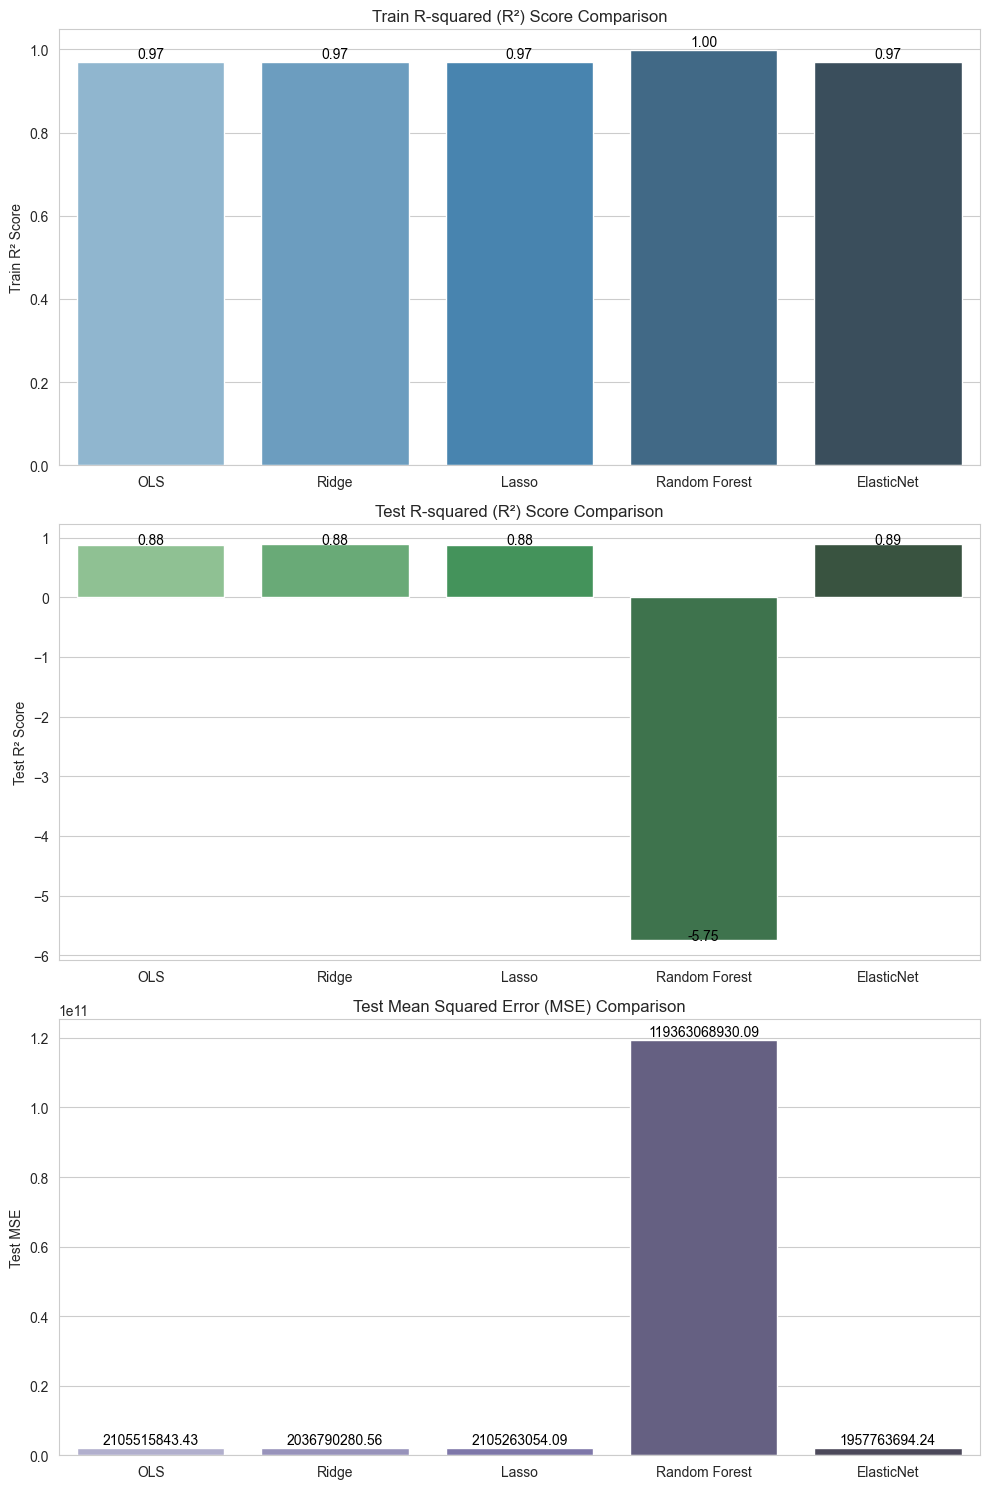

In [17]:
# Training R² and test MSE for each model
train_r2_scores = [
    ols_model.score(X_train, y_train),
    ridge_model.score(X_train, y_train),
    lasso_model.score(X_train, y_train),
    rf_model.score(X_train, y_train),
    elastic_net_model.score(X_train, y_train)
]

test_mse_scores = [
    mean_squared_error(y_test, y_pred_ols),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_en)
]

score_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Train R²': train_r2_scores,
    'Test R²': r2_values,
    'Test MSE': test_mse_scores
})

score_comparison_df.set_index('Model', inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Train R² plot
sns.barplot(ax=ax[0], x=model_names, y=train_r2_scores, palette="Blues_d")
ax[0].set_title('Train R-squared (R²) Score Comparison')
ax[0].set_ylabel('Train R² Score')
for i, v in enumerate(train_r2_scores):
    ax[0].text(i, v + max(train_r2_scores)*0.01, f"{v:.2f}", color='black', ha='center')

# Test R² plot
sns.barplot(ax=ax[1], x=model_names, y=r2_values, palette="Greens_d")
ax[1].set_title('Test R-squared (R²) Score Comparison')
ax[1].set_ylabel('Test R² Score')
for i, v in enumerate(r2_values):
    ax[1].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

# Test MSE plot
sns.barplot(ax=ax[2], x=model_names, y=test_mse_scores, palette="Purples_d")
ax[2].set_title('Test Mean Squared Error (MSE) Comparison')
ax[2].set_ylabel('Test MSE')
for i, v in enumerate(test_mse_scores):
    ax[2].text(i, v + max(test_mse_scores)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


### Comparison of Actual and Predicted

In [18]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

y_pred_ols = ols_model.predict(X_test)

# Ridge regression with GridSearchCV
ridge = Ridge()
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Random Forest
random_forest = RandomForestRegressor(random_state=0)
parameters_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}
rf_cv = GridSearchCV(random_forest, parameters_rf, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_
rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ElasticNet
elastic_net = ElasticNet()
parameters_en = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}
en_cv = GridSearchCV(elastic_net, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

predictions = {
    'Actual': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'Random_Forest': y_pred_rf,
    'ElasticNet': y_pred_en
}

predictions_df = pd.DataFrame(predictions)
predictions_df.reset_index(drop=True, inplace=True)

test_years = X_test['Year'].tolist()
predictions_df['Year'] = test_years
predictions_df = predictions_df.astype(int)
predictions_df = predictions_df[['Year', 'Actual', 'OLS', 'Ridge', 'Lasso', 'Random_Forest', 'ElasticNet']]
predictions_df


,Year,Actual,OLS,Ridge,Lasso,Random_Forest,ElasticNet
0,2018,4884896,4950789,4949880,4950786,4766881,4948790
1,2019,4958471,5012006,5011024,5012002,4766881,5009850
2,2020,5029875,5073458,5072402,5073454,4766881,5071137
3,2021,5074668,5129862,5128804,5129858,4760795,5127538
4,2022,5183966,5197552,5196328,5197547,4766881,5194864
5,2023,5281612,5264448,5263071,5264443,4712486,5261422


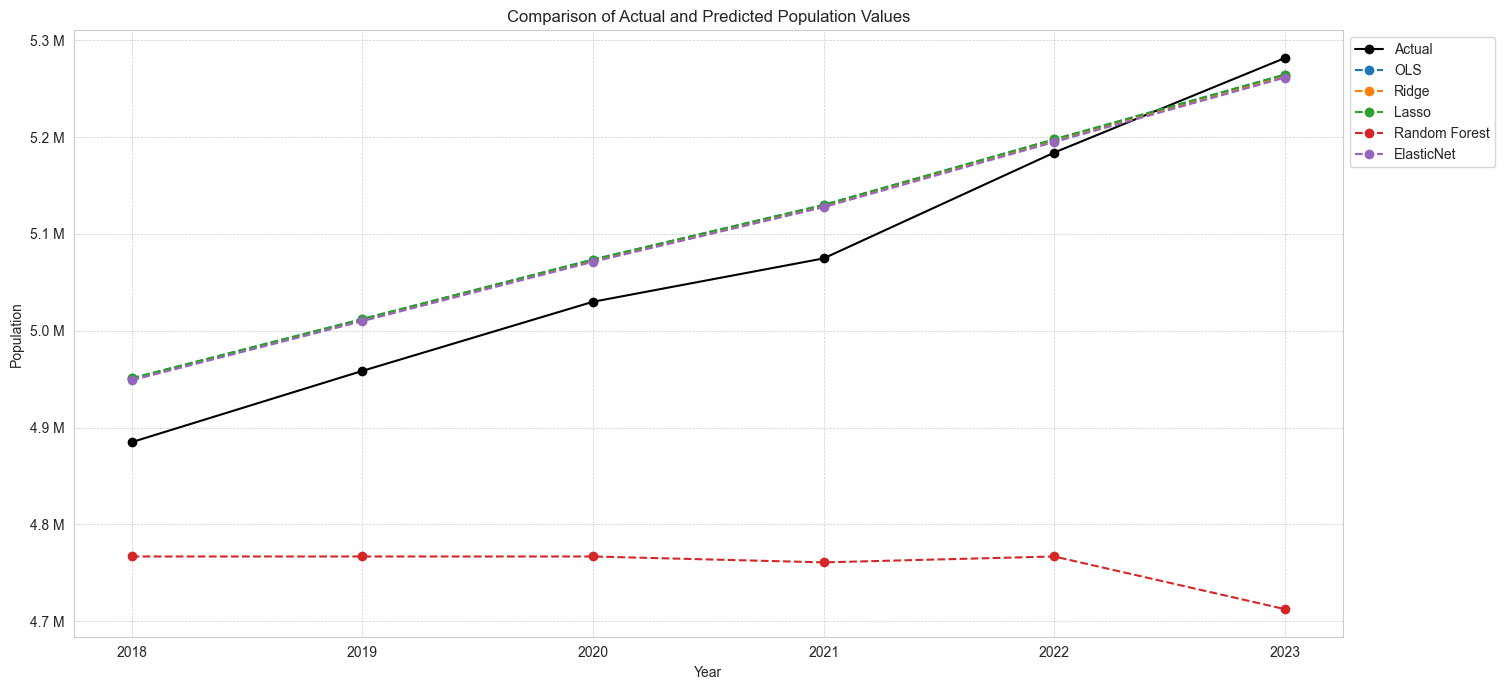

In [19]:
# Plotting the actual and predicted population values
plt.figure(figsize=(15, 7))

plt.plot(predictions_df['Year'], predictions_df['Actual'], label='Actual', color='black', marker='o')

plt.plot(predictions_df['Year'], predictions_df['OLS'], label='OLS', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Ridge'], label='Ridge', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Lasso'], label='Lasso', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Random_Forest'], label='Random Forest', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['ElasticNet'], label='ElasticNet', linestyle='--', marker='o')

plt.title('Comparison of Actual and Predicted Population Values')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(predictions_df['Year'].values)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

The plot above illustrates the actual population values compared with the predictions made by each model for the years in the test set. The solid black line represents the actual population, while the dashed lines represent the predictions from the various regression models. The visual comparison help us to understand how well each model is able to track the actual population trend.​

**Insights**
The actual population shows a steady increase over the years in the dataset.

**Model Performance:**

* **OLS, Ridge, Lasso, and ElasticNet** models show a relatively similar performance in terms of following the trend of the actual population. This indicates that despite the regularization terms in Ridge, Lasso, and ElasticNet, the linear nature of these models produces similar results.
* The **Random Forest** model exhibits a different pattern, with predictions that are consistently lower than the actual population figures and the other models predictions. This suggests that the Random Forest model might not have captured the trend in the data as effectively as the linear models. This could be due to not having enough features that capture the time series nature of the data.
  
**Consistency:**

* The linear models **OLS, Ridge, Lasso, ElasticNet** are consistent with each other but tend to underestimate the population in later years. This might be because the trend is not perfectly linear and there might be other factors influencing population growth that are not captured by the model features.
* The **Random Forest** model's predictions are consistent within its own trend but are quite off from the actual data, indicating it may have missed key time-related dependencies or interactions between features.
  
**Potential for Improvement:**

* The deviations between the predictions and actual figures suggest that there may be non-linear patterns or additional factors that affect the population growth that are not being accounted for by the current features in the models.
* Incorporating additional features that could impact population growth, such as economic indicators, fertility rates, mortality rates, or even age division, might improve model performance.
* Since we're dealing with time series data, using models that can capture temporal dynamics, such as ARIMA (Autoregressive Integrated Moving Average), SARIMA (Seasonal ARIMA), or LSTM (Long Short-Term Memory networks), could potentially provide more accurate predictions.\
**Unfortunately, these models cannot be applied with the data we currently have to provide us with the expected and more accurate predictions.**
  
**Projection to Future:**

* If we were to use these models to project future population, the current evidence suggests that the linear models would likely give similar trajectories, but the actual future population could be higher than predicted if recent trends continue.
* The **Random Forest** model would likely underestimate future population unless it's **retrained with additional data or more complex features** that better capture the underlying population dynamics.
In conclusion, while the linear models seem to perform adequately, **there is room for improvement**, especially in capturing non-linear trends and other potential influences on population growth. Advanced time series models or machine learning approaches that can handle sequences and external factors could provide better insights and predictions.